# Miniscule sample of production code
---
This notebook is mainly used as a sandbox and to visualize results of code fragments before adding them to the production pipeline

<br>
<hr>
<br>

<a id='toc'></a>
### Table of Contents
[1. Convert PDFs to images](#section-1)<br>
[2. Use PyTesseract for page segmentation](#section-2)<br>
[3. Image preprocessing](#section-3)<br>
[4. Text extraction using OCR](#section-4)<br>
[5. Text segmentation using RegEx](#section-5)<br>
[6. Extract chemical structures](#section-6)<br>
[7. Extract chemical names from text](#section-7)<br>
[8. Creating Dataframe](#section-8)<br>
[9. Text preprocessing](#section-9)<br>
[8. Text tokenization](#section-10)<br>
<br>
<hr>

<a id='section-1'></a>
### - Convert PDFs to images

In [2]:
# Loading dependencies
from pdf2image import convert_from_path
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)

In [3]:
# Start converting pdf pages into separate images
pages = convert_from_path('../PDFs/US20190030051.pdf', dpi=600, fmt='png',
                         output_folder='./sandbox/images/pdf_to_img')

<hr>
<br>

<a id='section-2'></a>

### - Use PyTesseract for page segmentation

In [1]:
# Loading dependencies
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob

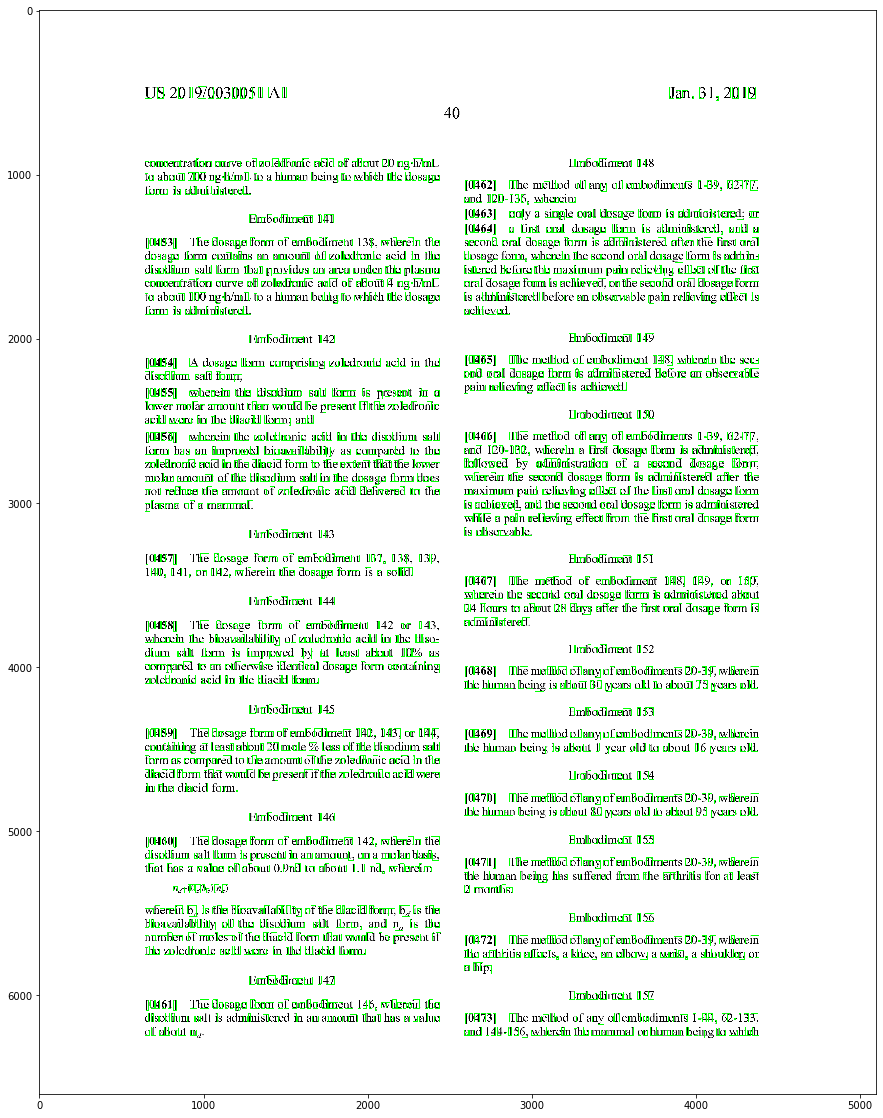

In [2]:
# Loop through all images in the folder
for image in glob.glob('sandbox/images/pdf_to_img/*.png'):
    # Read the image and get the dimensions
    img = cv2.imread(image)
    h, w, _ = img.shape

    # Run tesseract method to get bounding boxes around recognized characters
    boxes = pytesseract.image_to_boxes(
        Image.open(image))

    # Draw the bounding boxes on the image
    for b in boxes.splitlines():
        b = b.split(' ')
        img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

    # Save image with bounding boxes
    plt.imsave('sandbox/images/img_segmentation/' + image[27:-3] + 'png', img)
    
# Show page with bounding boxes
fig = plt.figure(figsize = (15,30))
plt.imshow(img)
plt.show()

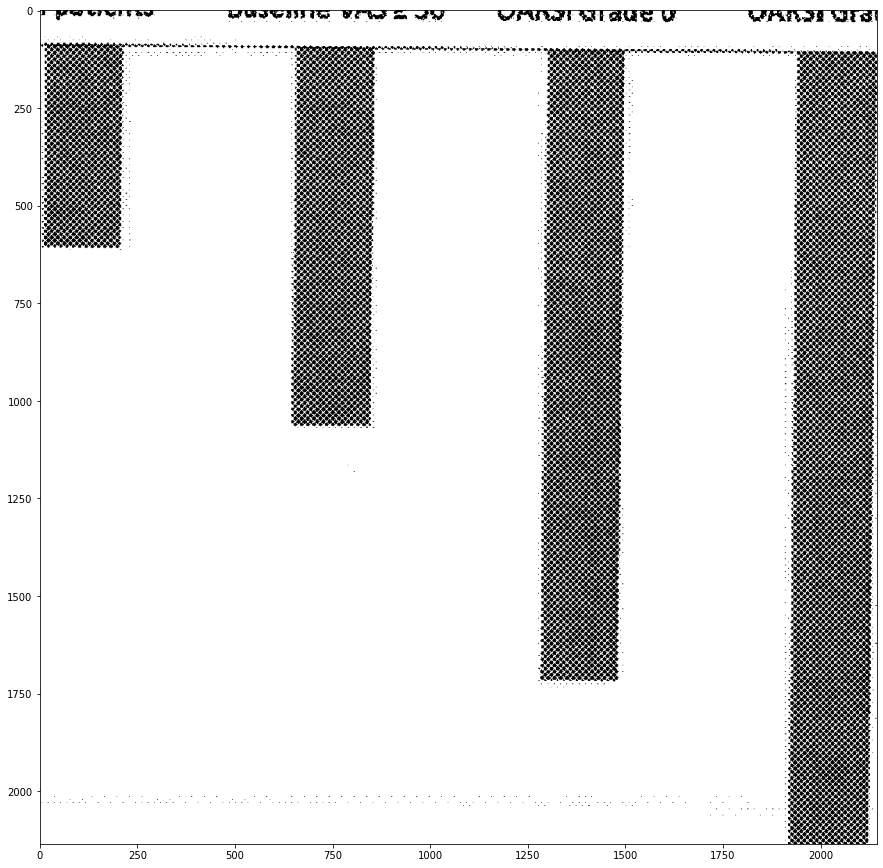

In [3]:
# Loop through all images in the folder
for image in glob.glob('sandbox/images/pdf_to_img/*.png'):
    
    # Read the image and get the dimensions
    img2 = cv2.imread(image)
    h, w, _ = img2.shape

    # Run tesseract method to get bounding boxes around recognized characters
    boxes = pytesseract.image_to_boxes(
        Image.open(image))

    # Loop through all bounding boxes
    for b in boxes.splitlines():
        b = b.split(' ')
        
        # Extract figures from a page and save them
        images = []
    
        # Check for dimensions of bound box, if they exceed 800px for width and height
        # consider the box containing a figure and crop it out
        if (int(b[3]) - int(b[1]) > 800) and ((h - int(b[2])) - (h - int(b[4])) > 800):
            images.append([int(b[2]), int(b[4]), int(b[1]), int(b[3])])
            crop = img2[images[0][0]:images[0][1], images[0][2]:images[0][3]]
            plt.imsave('./sandbox/images/figure_extraction/' + image[27:-3] + 'png', crop)

# Show extracted figure
fig2 = plt.figure(figsize = (15,30))
plt.imshow(crop)
plt.show()

<hr>
<br>

<a id='section-3'></a>

### - Image preprocessing

In [4]:
# Loading dependencies

import glob
import os
from PIL import Image
import cv2 as cv
import numpy as np

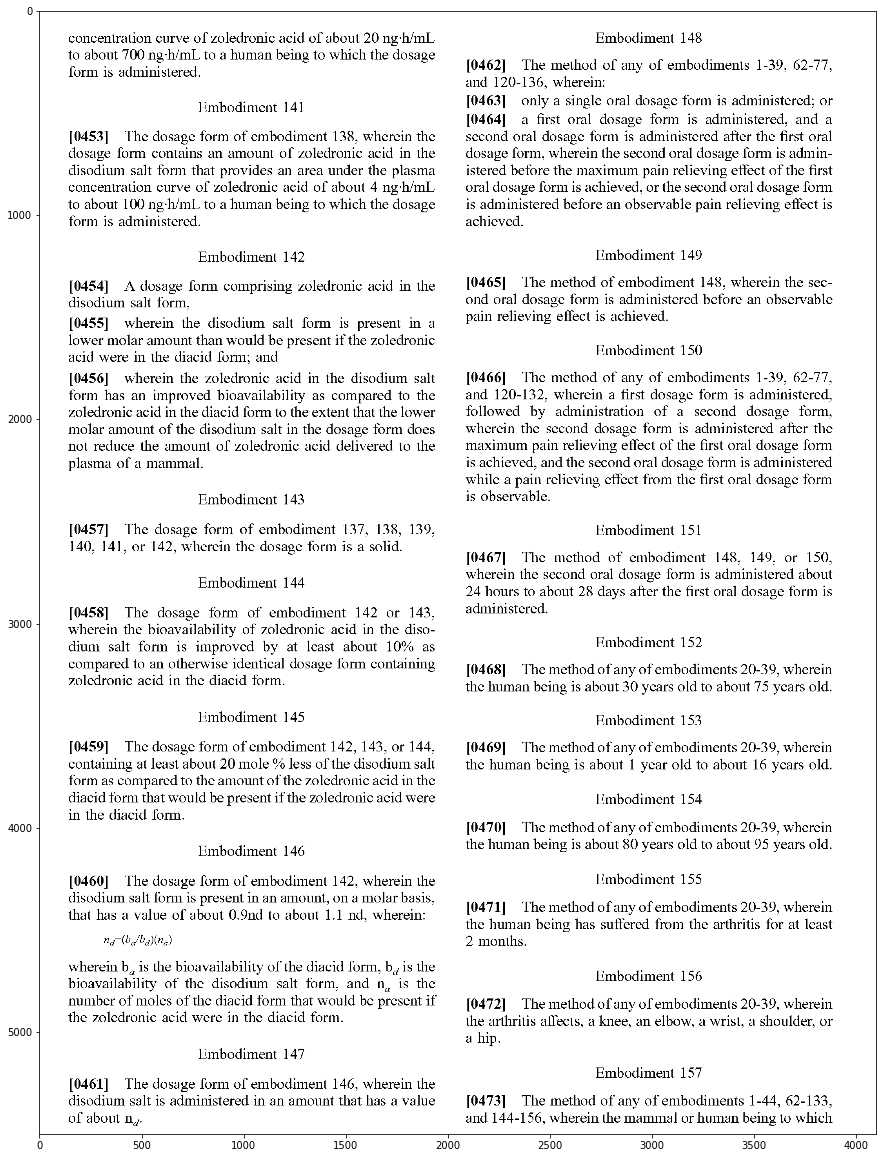

In [5]:
# Loop through all images in the folder
for image in glob.glob('sandbox/images/pdf_to_img/*.png'):

    # Apply thresholding to increase constrast of black characters
    # and increase tesseract reading accuracy
    img3 = cv.imread(image, 0)
    ret, thresh1 = cv.threshold(img3, 127, 255, cv.THRESH_BINARY)

    # Crop header and footer of each page and
    # remove white borders on the sides
    crop_img = img3[800:6300, 500:4600]

    # Change color space to be compatible with the format to save
    crop_img = cv.cvtColor(crop_img, cv.COLOR_BGR2RGB)

    # Save images of the current document
    cv.imwrite('sandbox/images/img_preprocessing/' + image[28:-3] + 'png', crop_img)

# Show preprocessed image
fig3 = plt.figure(figsize = (15,30))
plt.imshow(crop_img)
plt.show()

<hr>
<br>

<a id='section-4'></a>

### - Text extraction using OCR

In [5]:
# Loading dependencies
import glob
import os
from PIL import Image
import pytesseract

In [6]:
# Use pytesseract to extract text from images (scans) of documents
text_array = []

# Loop through all pages for a patent
for image in glob.glob('sandbox/images/img_preprocessing/*.png'):
    print('Reading from image', image[-6:-4])
    text_array.append(pytesseract.image_to_string(Image.open(image)))

# Convert array items to string
text = ''.join(text_array)

# Write to text file
with open('sandbox/text/raw/patent.txt', 'w') as text_file:
    text_file.write(text)

print(text)

Reading from image 40
Reading from image 54
Reading from image 09
Reading from image 31
Reading from image 32
Reading from image 71
Reading from image 64
Reading from image 36
Reading from image 01
Reading from image 18
Reading from image 37
Reading from image 16
Reading from image 50
Reading from image 51
Reading from image 07
Reading from image 28
Reading from image 24
Reading from image 49
Reading from image 06
Reading from image 03
Reading from image 12
Reading from image 68
Reading from image 53
Reading from image 65
Reading from image 17
Reading from image 60
Reading from image 15
Reading from image 48
Reading from image 27
Reading from image 11
Reading from image 38
Reading from image 26
Reading from image 25
Reading from image 55
Reading from image 41
Reading from image 62
Reading from image 21
Reading from image 63
Reading from image 33
Reading from image 44
Reading from image 46
Reading from image 52
Reading from image 43
Reading from image 42
Reading from image 58
Reading fr

<hr>
<br>

<a id='section-5'></a>

### - Text segmentation using RegEx

In [93]:
import re
import glob
import os

In [94]:
def find_inbetween_text(text, sub1, sub2):
    """
    This function accepts a piece of text and extracts what's
    between any two given strings after finding their positions
    """
    
    # Get positions for the two strings
    pos1 = sub1
    pos2 = sub2
    
    if pos1 > pos2 and pos2 >= 0:
        return text[pos2:pos1]
    elif pos2 > pos1 and pos1 >= 0:
        return text[pos1:pos2]

In [95]:
text = ''

with open('sandbox/text/raw/patent.txt', 'r') as text_file:
    text += text_file.read()

In [96]:
# Get document id from file name (one file only as example)
_ids = []

for _file in glob.glob('../PDFs/*'):
    _ids.append(str(_file[10:-4]))

print(_ids)

# Since already a specific file was used in the beginning
# the id will be for that file
_id = '20190030051'

['20190033290', '20190030209', '20190031685', '20190031656', '20190030119', '20190031721', '20190029961', '20190029995', '20190029958', '20190030161', '20190032012', '20190030008', '20190030015', '20190032087', '20190030115', '20190029978', '20190030182', '20190031686', '20190031651', '20190032058', '20190029258', '20190030133', '20190031679', '20190031980', '20190029980', '20190030055', '20190029968', '20190030032', '20190030051', '20190029253']


In [97]:
# Get document title
# by manually investigating patent document structure
# it was found that they have identical numbered sections
# the title carries the number (54), this will be used
# to extract title using RegEx

pos = result = title = ''

try:
    pos = re.search('\(54\)((\()*([0-9])*(\))*(\s)*)*((\s)*([A-Z])*)*', text, re.MULTILINE)
    result = str(pos.group())

    # Do some cleaning and extract only the title knowing the
    # the fact that it is always uppercase
    title = re.search('(([A-Z])+\s)+', result, re.MULTILINE).group().replace('\n', ' ')
except(AttributeError):
    pos = result = title = ''
print(title)

DOSAGE FORMS FOR ORAL ADMINISTRATION OF ZOLEDRONIC ACID OR RELATED COMPOUNDS FOR TREATING DISEASE 


In [98]:
# Use similar method to identify the beginning of abstract section
abstract = ''

try:
    pos_abstract = re.search('ABSTRACT', text, re.MULTILINE).end()
    # Start searching again from the current position where ABSTRACT was found
    # adding 150 characters as minimum for the content
    text_sub = text[pos_abstract+150:]
    # Search for 2 or more empty spaces which may suggest an end of a paragraph
    # which is usually the length of abstract content
    pos_after_abstract = re.search('(\s){2,}', text_sub, re.MULTILINE).start() + pos_abstract + 150

    # Extract text between the two positions calculated
    abstract = find_inbetween_text(text, pos_abstract, pos_after_abstract)
except(AttributeError):
    abstract = ''
print(abstract)



Oral dosage forms of osteoclast inhibitors, such as zole-
dronic acid, in an acid or a salt form can be used to treat or
alleviate pain or related conditions, such as arthritis.Ne ove renter mya purse nen rere yee wr


In [99]:
# Use similar method to identify the beginning of claims section
claims = ''

try:
    pos_claims = re.search('is claimed', text).end()

    # Start searching again from the current position where 'is claimed' was found
    # adding 5 characters as minimum for extra characters/spaces before content
    claims = text[pos_claims+5:]
except(AttributeError):
    claims = ''
print(claims)


1. A method of treating arthritis comprising administering
an oral dosage form containing zoledronic acid, in an acid
form or a salt form, to a human being in need thereof,
wherein the human being receives a total amount of about
100 mg to about 500 mg of the zoledronic acid, wherein the
oral dosage form does not contain a bioavailability enhancer,
wherein the human being has been fasted for at least 1 hour
before the administration of the dosage form and continues
to fast for at least 1 hour after the administration of the
dosage form, and wherein the human being experiences pain
relief that lasts for a duration of at least 48 hours, and the
human being receives the dosage form no more often than
once daily.

2. The method of claim 1, wherein the zoledronic acid is
in the free acid form.

3. The method of claim 1, wherein the zoledronic acid is
in the salt form.

4. The method of claim 3, wherein the zoledronic acid is
in a disodium salt form.

5. The method of claim 1, wherein the h

In [100]:
# Use similar method to identify the beginning of cross-refernce section
cross_reference = ''
try:
    pos_ref = re.search('CROSS-REFERENCE', text, re.MULTILINE).start()

    # Search for a specific substring that is usually present at the
    # end of each cross-reference section
    pos_after_ref = re.search('by reference in their entirety', text, re.MULTILINE).end()

    # Extract text between the two positions calculated
    cross_reference = find_inbetween_text(text, pos_ref, pos_after_ref)
except(AttributeError):
    cross_reference = ''
print(cross_reference)

CROSS-REFERENCE TO RELATED
APPLICATIONS

[0001] This application is a continuation-in-part of U.S.
patent application Ser. No. 15/432,777, filed Feb. 14, 2017;
which is a continuation-in-part of U.S. patent application
Ser. No. 15/136,092, filed Apr. 22, 2016, now U.S. Pat. No.
9,616,078; which is a continuation-in-part of U.S. patent
application Ser. No. 15/043,281, filed Feb. 12, 2016, now
U.S. Pat. No. 9,517,242; which is a continuation of U.S.
patent application Ser. No. 14/279,196, filed May 15, 2014,
now U.S. Pat. No. 9,301,964; which is a continuation of U.S.
patent application Ser. No. 14/063,979, filed Oct. 25, 2013,
now U.S. Pat. No. 8,802,658; which is a continuation-in-part
of U.S. patent application Ser. No. 13/894,274, filed May 14,
2013, now abandoned; which claims the benefit of U.S.
Prov. App. Nos. 61/646,538, filed May 14, 2012; 61/647,
478, filed May 15, 2012; 61/654,292, filed Jun. 1, 2012;
61/654,383, filed Jun. 1, 2012; 61/655,527, filed Jun. 5,
2012; 61/655,541, 

In [101]:
# Use similar method to identify the beginning of summary section
summary = ''

try:
    pos_summary = re.search('SUMMARY', text, re.MULTILINE).start()
    sub_summary = text[pos_summary+300:]

    # Search for a specific substring that is usually present at the
    # end of each cross-reference section
    pos_after_summary = re.search('(\s+([A-Z])+\s)+', sub_summary, re.MULTILINE).start() + pos_summary + 300

    # Extract text between the two positions calculated
    summary = find_inbetween_text(text, pos_summary, pos_after_summary)
except(AttributeError):
    summary = ''
print(summary)

SUMMARY

[0002] Bisphosphonate compounds are potent inhibitors
of osteoclast activity, and are used clinically to treat bone-
related conditions such as osteoporosis and Paget’s disease
of bone; and cancer-related conditions including multiple
myeloma, and bone metastases from solid tumors. They
generally have low oral bioavailability.

[0003] Patchy osteoporosis and bone marrow edema may
result from osteoclast hyperactivity. Zoledronic acid is a
potent inhibitor of bone resorption and osteoclast activity.
Nitrogen containing bisphosphonates, such as zoledronic
acid, also inhibit the mevalonate pathway in the osteoclast
thereby interrupting normal osteoclast function.

[0004] It has been discovered that oral dosage forms of
bisphosphonate compounds, such as zoledronic acid, can be
used to treat or alleviate pain or related conditions.

[0005] Some embodiments include a method of enhancing
the oral bioavailability of zoledronic acid comprising orally
administering a dosage form containi

In [102]:
# Use similar method to identify the beginning of background section
bg = ''

try:
    pos_bg = re.search('([A-Z])*BACKGROUND(([A-Z])*(\s))*', text, re.MULTILINE).start()

    # Search for summary section beginning which usually follows
    pos_after_bg = re.search('([A-Z])*SUMMARY(([A-Z])*(\s))*', sub_summary, re.MULTILINE).start()

    # Extract text between the two positions calculated
    bg = find_inbetween_text(text, pos_bg, pos_after_bg)
except(AttributeError):
    bg = ''
print(bg)

In [103]:
# Use similar method to identify the beginning of detailed description section
desc = ''

try:
    pos_desc = re.search('DETAILED DESCRIPTION', text, re.MULTILINE).start()

    # Search for a specific substring that is usually present at the
    # beginning of claims section which directly follows the description
    pos_after_desc = re.search('is claimed', text, re.MULTILINE).start()

    # Extract text between the two positions calculated
    desc = find_inbetween_text(text, pos_desc, pos_after_desc-5)
except(AttributeError):
    desc = ''
print(desc)

DETAILED DESCRIPTION

[0040] Inhibitors of osteoclast activity include bisphos-
phonate compounds such as pamidronate or pamidronic
acid, neridronate or neridronic acid, olpadronate or olpad-
ronic acid, alendronate or alendronic acid, incadronate or
incadronic acid, ibandronate or ibandronic acid, risedronate
or risedronic acid, cimadronate or cimadronic acid, zoledro-
nate or zoledronic acid, etidronate or etidronic acid, clodro-
nate or clodronic acid, tiludronate or tiludronic acid, etc.

[0041] RANK/RANKL antagonists may be inhibitors of
osteoclast activity. RANK/RANKL antagonists include but
are not limited to OPG (osteoprotegerin) or a variant thereof,
an anti-RANKL antibody such as denosumab, a monoclonal
anti-RANKL antibody, a small interfering RNA, a micro-
RNA, a precursor molecule, a ribozyme, an antisense
nucleic acid, or an aptamer targeting RANKL. Antibodies
such as AB-25E9, small molecules, small interfering RNAs,
microRNAs, precursor molecules, ribozymes, antisense
nuc

In [104]:
# Full description
description = cross_reference + bg + summary + desc + claims

In [105]:
# Extract drawings description section
drawings_desc = ''

try:
    pos_drawings_desc = re.search('([A-Z])*DRAWINGS(([A-Z])*(\s))*', text, re.MULTILINE).start()

    # Search for a specific substring that is usually present at the
    # beginning of claims section which directly follows the description
    pos_after_drawings_desc = re.search('DETAILED DESCRIPTION', text, re.MULTILINE).start()

    # Extract text between the two positions calculated
    drawings_desc = find_inbetween_text(text, pos_drawings_desc, pos_after_drawings_desc)
except(AttributeError):
    drawings_desc = ''
print(drawings_desc)

DRAWINGS

[0023] FIG. 1 1s a plot of pain compression thresholds in
a rat model of inflammatory pain using three different doses
of zoledronic acid. Measurements were taken at baseline
(BL) and at various time points after dosing on the days
indicated.

[0024] FIG. 2A is a graph depicting reversal of arthritis
pain for two different doses of zoledronic acid in a rat model
of arthritis pain.

[0025] FIG. 2B is a graph depicting pain thresholds for
two different doses of zoledronic acid in a rat model of
arthritis pain.

[0026] FIG. 3 is a graph summarizing the results for
vehicle and zoledronic acid treated rats in a rat model of
complex regional pain syndrome.

[0027] FIG. 4 depicts hindpaw pain thresholds for vehicle
and zoledronic acid treated rats in a rat model of complex
regional pain syndrome.

[0028] FIG. 5 depicts weight bearing for vehicle and
zoledronic acid treated rats in a rat model of complex
regional pain syndrome.

[0029] FIG. 6 depicts paw thickness change for vehicle


In [106]:
# Save drawings paths by itereating over image files extracted previously
# currently limited to png images only

images_paths = []

for img in glob.glob('sandbox/images/figure_extraction/*.png'):
    images_paths.append(img)
    
print(images_paths)

['sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-08.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-09.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-16.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-11.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-14.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-04.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-03.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-17.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-10.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-07.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-21.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5-9712-407a6fa03569-13.png', 'sandbox/images/figure_extraction/c2f8569-2f90-4eb5

<hr>
<br>

<a id='section-6'></a>

### - Extract chemical structures

In [1]:
# Loading dependencies
import subprocess
import glob

In [2]:
# Loop through all pages for a patent
for image in glob.glob('sandbox/images/img_preprocessing/*.png'):
    print('Reading from image', image[-6:-4])
    
    subprocess.check_call(['osra', image, \
                           '-w sandbox/text/chemical-names-smiles/' + str(image[33:-4]) + '.txt', \
                           '-o sandbox/images/chemical-structures/' + str(image[33:-4])])

Reading from image 40
Reading from image 54
Reading from image 09
Reading from image 31
Reading from image 32
Reading from image 71
Reading from image 64
Reading from image 36
Reading from image 01
Reading from image 18
Reading from image 37
Reading from image 16
Reading from image 50
Reading from image 51
Reading from image 07
Reading from image 28
Reading from image 24
Reading from image 49
Reading from image 06
Reading from image 03
Reading from image 12
Reading from image 68
Reading from image 53
Reading from image 65
Reading from image 17
Reading from image 60
Reading from image 15
Reading from image 48
Reading from image 27
Reading from image 11
Reading from image 38
Reading from image 26
Reading from image 25
Reading from image 55
Reading from image 41
Reading from image 62
Reading from image 21
Reading from image 63
Reading from image 33
Reading from image 44
Reading from image 46
Reading from image 52
Reading from image 43
Reading from image 42
Reading from image 58
Reading fr

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

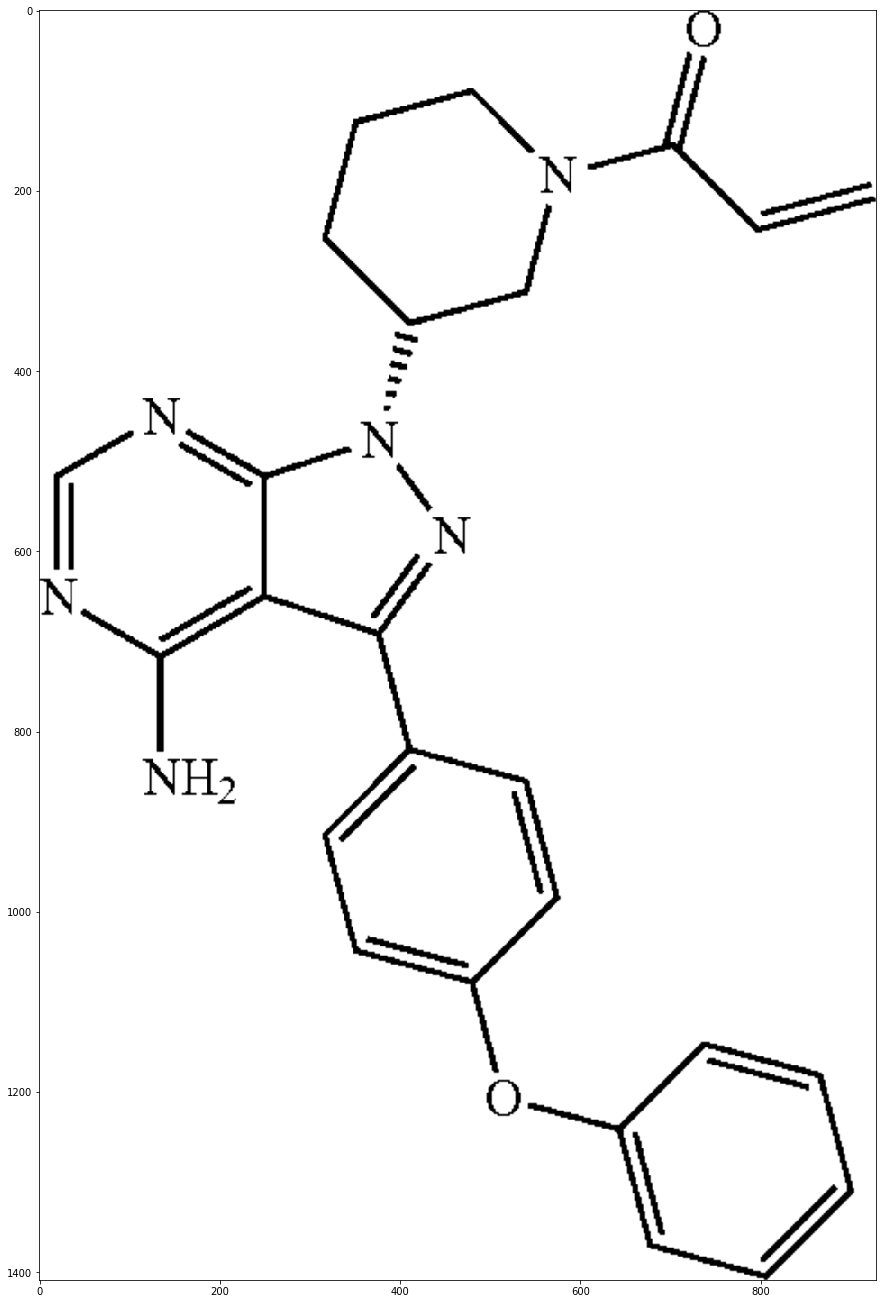

In [5]:
img_osra = cv2.imread('sandbox/images/chemical-structures/2f8569-2f90-4eb5-9712-407a6fa03569-210.png')
    
# Show page with bounding boxes
fig = plt.figure(figsize = (15,30))
plt.imshow(img_osra)

In [107]:
# Read extracted text to add it to the dataframe
smiles = []

# Loop through all folders and grab generated text files
for _file in glob.glob('sandbox/text/chemical-names-smiles/2f8569-2f90-4eb5-9712-407a6fa03569-21.txt'):
    one = ''
    
    with open(_file, 'r') as smiles_file:
        one = smiles_file.read()

    if one != '':
        smiles.append(one.split('\n'))

print(smiles[0])

['C=CC(=O)N1CCCC(C1)n1nc(c2c1ncnc2N)c1ccc(cc1)Oc1ccccc1', 'Cc1c(cccc1c1cn(C)c(=O)c(n1)Nc1ccc(cc1)C(=O)N1CCOCC1)NC(=O)c1ccc(cc1)C(C)(C)C', 'COCCOc1ccc(cc1)Nc1ncc(c(n1)Nc1cccc(c1)NC(=O)C=C)F', 'C=CC(=O)Nc1cccc(c1)Nc1nc(ncc1[Fl])[Ne]c1ccc(cc1)Oc1ccnc(c1)C(=O)*C', 'C/C(=C(/C(=O)Nc1cc(Br)ccc1Br)\\C#N)/O', 'CN1CCN(C(=O)C1c1ccc(cc1)*C1=NC(=C*(C1=O)C)c1cccc(c1C)NC(=O)c1cc2c(s1)CCCC2)C', 'OC(=O)Cn1ccn(c1)CC(O)(*)*', '*C(Cn1ccn(c1)CC(O)(*)*)(O)*', 'OCCN1CCN(CC1)C1=*C(=*C(=C1)NC1=*C=C(S1)C(=O)Nc1c(C)cccc1Cl)C', 'O=C(c1ccc(cc1)C(C)(C)C)Nc1cccc(c1)C1=Cn2c(C(=*1)Nc1ccccc1)ncc2', '']


<hr>
<br>

<a id='section-7'></a>

### - Extract chemical names from text

In [3]:
# Loading dependencies
import subprocess
import glob
import re

In [37]:
# Chemspot accepts only text files as input, so we write the description
# extracted previously to file
with open('sandbox/text/segmented_by_section/description.txt', 'w') as description_file:
    description_file.write(description)

In [63]:
# Extract from full patent description
print('Chemical NER extraction')

# Run ChemSpot, the Chemical named entity recognition library (in shell)
subprocess.check_call(['java', '-Xmx4G', '-jar', '../chemspot-2.0/chemspot.jar', \
    '-t', 'sandbox/text/segmented_by_section/description.txt', '-o', \
                       'sandbox/text/chemical-names-inchi/2f8569-2f90-4eb5-9712-407a6fa03569-21.txt', \
                      '-i "" -M ""']) 

Chemical NER extraction


0

In [108]:
# Read extractions file
with open('sandbox/text/chemical-names-inchi/2f8569-2f90-4eb5-9712-407a6fa03569-21.txt', 'r') as extraction:
    ext = extraction.read()
    
print(ext)

	4496	4511	bis-
phosphonate	SYSTEMATIC													
	6700	6712	zoledro-
nate	SYSTEMATIC													
	6764	6775	clodro-
nate	SYSTEMATIC													
	7582	7615	Benzo|[b]thiophene-2-carbox-
amide	SYSTEMATIC													
	7618	7762	N-[3-[6-[[4-[(2R)-1,4-dimethyl-3-oxo-2-piperazi-
nyl|phenyl]amino]-4,5-dihydro-4-methyl-5-oxo-2-pyrazi-
nyl]-2-methylpheny] |-4,5,6,7-tetrahydro-	SYSTEMATIC													
	7795	7825	4-(1,1-dimethylethyl)-N-[3-[8-(	SYSTEMATIC													
	7899	8031	N-[3-[4,5-dihydro-4-methy1-6-[[4-(4-morpholi-
nylcarbony])pheny1] amino |-5-oxo-2-pyraziny1]-2-methyl-
phenyl]-4-(1,1-dimethylethyl)-	SYSTEMATIC													
	8083	8095	2-Propenamide	SYSTEMATIC													
	8098	8163	N-[3-[[5-
fluoro-2-[[4-(2-methoxyethoxy) phenyl ]amino]-4-pyrimidi	SYSTEMATIC													
	8227	8247	2-Pyridinecarboxamide	SYSTEMATIC													
	8250	8356	4-[4-[[5-fluoro-4-[[3-[(1-
oxo-2-propen-1-yl)amino]phenyl ]amino ]-2-pyrimidiny]]
amino|phenoxy |-N-methyl-	SYSTEMATIC													
	8529	8651	[N

In [109]:
# The output needs some preprocessing before storage
# it is not regularly spaced so cannot use panadas read as csv with delimiter
clean = ''
with open('sandbox/text/chemical-names-inchi/2f8569-2f90-4eb5-9712-407a6fa03569-21.txt', 'r') as extraction:
    for line in extraction:
        if len(line) > 4:
            begin = re.search('(\s*[0-9]{4}){2}', line)
            final = re.search('\s([A-Z]{2,})', line)
            
            start = ''
            end = ''
            
            if begin != None and final == None:
                start = begin.end()
                end = len(line)
            elif begin == None and final == None:
                start = 0
                end = len(line)
            elif begin == None and final != None:
                start = 0
                end = final.start()
            elif begin != None and final != None:
                start = begin.end()
                end = final.start()

            # Append the extracted compound to a global array
            clean += find_inbetween_text(line, start, end)

print(clean)

	bis-
phosphonate	zoledro-
nate	clodro-
nate	Benzo|[b]thiophene-2-carbox-
amide	N-[3-[6-[[4-[(2R)-1,4-dimethyl-3-oxo-2-piperazi-
nyl|phenyl]amino]-4,5-dihydro-4-methyl-5-oxo-2-pyrazi-
nyl]-2-methylpheny] |-4,5,6,7-tetrahydro-	4-(1,1-dimethylethyl)-N-[3-[8-(	N-[3-[4,5-dihydro-4-methy1-6-[[4-(4-morpholi-
nylcarbony])pheny1] amino |-5-oxo-2-pyraziny1]-2-methyl-
phenyl]-4-(1,1-dimethylethyl)-	2-Propenamide	N-[3-[[5-
fluoro-2-[[4-(2-methoxyethoxy) phenyl ]amino]-4-pyrimidi	2-Pyridinecarboxamide	4-[4-[[5-fluoro-4-[[3-[(1-
oxo-2-propen-1-yl)amino]phenyl ]amino ]-2-pyrimidiny]]
amino|phenoxy |-N-methyl-	[N-(2-chloro-6-
methylpheny])-2-(6-(4-(2-hydroxyethyl) piperazin-1-yl)-2-
methylpyrimidin-4-ylamino )thiazole-5-carboxamide6	bis-
phosphonate1	nitrogen-bisphosphonate8	nitrogen-bisphosphonate


In [110]:
new_clean = clean.split('\n')
inchi = []

connect = ''
for item in new_clean:
    string = ''
    #print('item: ' + item, '\n')
    if item[-1] == '-':
        string += item[:-1]
        #print(connect)    
    connect += string.replace('\t', ' ')

inchi = connect.split(' ')
print(inchi)

['', 'bisphosphonate', 'zoledronate', 'clodronate', 'Benzo|[b]thiophene-2-carboxamide', 'N-[3-[6-[[4-[(2R)-1,4-dimethyl-3-oxo-2-piperazinyl|phenyl]amino]-4,5-dihydro-4-methyl-5-oxo-2-pyrazinyl]-2-methylpheny]', '|-4,5,6,7-tetrahydro-', '4-(1,1-dimethylethyl)-N-[3-[8-(', 'N-[3-[4,5-dihydro-4-methy1-6-[[4-(4-morpholinylcarbony])pheny1]', 'amino', '|-5-oxo-2-pyraziny1]-2-methylphenyl]-4-(1,1-dimethylethyl)-', '2-Propenamide', 'N-[3-[[5fluoro-2-[[4-(2-methoxyethoxy)', 'phenyl', ']amino]-4-pyrimidi', '2-Pyridinecarboxamide', '4-[4-[[5-fluoro-4-[[3-[(1amino|phenoxy', '|-N-methyl-', '[N-(2-chloro-6methylpheny])-2-(6-(4-(2-hydroxyethyl)', 'piperazin-1-yl)-2methylpyrimidin-4-ylamino', ')thiazole-5-carboxamide6', 'bis']


<hr>
<br>

<a id='section-8'></a>

### - Create Dataframe

In [111]:
# Loading dependencies
import pandas as pd

In [113]:
new_document = pd.DataFrame({'id': _id, \
                             'invention_title': title, \
                             'abstract': abstract, \
                             'claims': claims, \
                             'description': description, \
                             'drawings_description': drawings_desc, \
                             'drawings_file_paths': [images_paths], \
                             'invention_background': bg, \
                             'cross_reference': cross_reference, \
                              'summary': summary, \
                             'detailed_description': desc, \
                            'chemical_compounds_smiles': smiles, \
                            'chemical_compounds_inchi': [inchi]})
new_document    

,id,invention_title,abstract,claims,description,drawings_description,drawings_file_paths,invention_background,cross_reference,summary,detailed_description,chemical_compounds_smiles,chemical_compounds_inchi
0,20190030051,DOSAGE FORMS FOR ORAL ADMINISTRATION OF ZOLEDR...,\n\nOral dosage forms of osteoclast inhibitors...,\n1. A method of treating arthritis comprising...,CROSS-REFERENCE TO RELATED\nAPPLICATIONS\n\n[0...,DRAWINGS\n\n[0023] FIG. 1 1s a plot of pain co...,[sandbox/images/figure_extraction/c2f8569-2f90...,,CROSS-REFERENCE TO RELATED\nAPPLICATIONS\n\n[0...,SUMMARY\n\n[0002] Bisphosphonate compounds are...,DETAILED DESCRIPTION\n\n[0040] Inhibitors of o...,[C=CC(=O)N1CCCC(C1)n1nc(c2c1ncnc2N)c1ccc(cc1)O...,"[, bisphosphonate, zoledronate, clodronate, Be..."


In [116]:
# Write resulting dataframe to csv
new_document.to_csv('sandbox/test-new-document.csv', index=False)

<hr>
<br>

<a id='section-9'></a>

### - Text Preprocessing

In [119]:
def preprocessText(text):
    """
    This function operates on any piece of text and applies
    transformation so it is "clean" and ready for the next step
    in the NLP pipeline
    """
    
    if type(text) == str:
        # Remove unwanted characters
        unwanted_chars = set(['/', "'", '"', '\\', '', '\\n', '\n', '\t'
                              '?', '#', '%', '$', '&', ';', '!', ';', "_"])

        for char in unwanted_chars:
            text = text.replace(char, '')

        # Convert all text into lowercase
        text = text.lower()

        return text
    else:
        return text

In [127]:
# Apply text preprocessing on the dataframe
new_document_preprocessed = new_document.applymap(lambda x: preprocessText(x))

new_document_preprocessed

,id,invention_title,abstract,claims,description,drawings_description,drawings_file_paths,invention_background,cross_reference,summary,detailed_description,chemical_compounds_smiles,chemical_compounds_inchi
0,20190030051,dosage forms for oral administration of zoledr...,"oral dosage forms of osteoclast inhibitors, su...",1. a method of treating arthritis comprising a...,cross-reference to relatedapplications[0001] t...,drawings[0023] fig. 1 1s a plot of pain compre...,[sandbox/images/figure_extraction/c2f8569-2f90...,,cross-reference to relatedapplications[0001] t...,summary[0002] bisphosphonate compounds are pot...,detailed description[0040] inhibitors of osteo...,[C=CC(=O)N1CCCC(C1)n1nc(c2c1ncnc2N)c1ccc(cc1)O...,"[, bisphosphonate, zoledronate, clodronate, Be..."


<hr>
<br>

<a id='section-10'></a>

### - Text Tokenization

In [128]:
# Loading dependencies
import tensorflow as tf

In [142]:
def tokenize(text):
    """
    This function is a method to vectorize text. It operates on any piece of
    text and applies tokenization where text is split and converted into a 
    sequence of integers that represent the indices tokens in a dictionary
    """
    
    if type(text) != int or type(text) != list:
        # Instantiate Tensorflow's keras tokenizer and set filter to none (empty string)
        # as the text preprocessing has already been don separately
        text_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', \
                                                              lower=False)

        # Apply tokenizer to text
        text_tokenizer.fit_on_texts(text)

        # Convert text into sequence of integers
        tensor = text_tokenizer.texts_to_sequences(text)

        # Apply padding so all tensors of tokenized text
        # have the same size, apply padding to the end of the tensor
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                             padding='post')

        return tensor#, text_tokenizer
    else:
        return text

In [144]:
# Apply tokenization to selected fields in the dataframe
# as some features will be used as is in other comparison methods
new_document_preprocessed = new_document_preprocessed.applymap(lambda x:tokenize(str(x)))
new_document_preprocessed

ValueError: ('zero-size array to reduction operation maximum which has no identity', 'occurred at index invention_background')